In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install utils torch numpy einops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cach

In [3]:
import torch
import os
import numpy as np
from datetime import datetime
import argparse
import sys

%cd /content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC
path = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC'
os.chdir(path)
sys.path.append(path)

from utils import _logger, set_requires_grad
from dataloader.dataloader import data_generator
from trainer.trainer import Trainer, model_evaluate
from models.TC import TC
from utils import _calc_metrics, copy_Files
from models.model import base_Model
# Args selections
start_time = datetime.now()

#maybe something to do with (not torch = th) th.randperm

/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC


In [4]:
#drive.flush_and_unmount()

DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:=============================================


Dataset: ECG5000


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Dataset: ECG5000


Method:  TS-TCC


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Method:  TS-TCC


Mode:    train_linear


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Mode:    train_linear


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:=============================================


Data loaded ...


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Data loaded ...


Training started ....


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Training started ....
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 1
Train Loss     : 1.0456	 | 	Train Accuracy     : 0.5417
Valid Loss     : 1.0454	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 1
Train Loss     : 1.0456	 | 	Train Accuracy     : 0.5417
Valid Loss     : 1.0454	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 2
Train Loss     : 0.5339	 | 	Train Accuracy     : 0.8906
Valid Loss     : 1.3869	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 2
Train Loss     : 0.5339	 | 	Train Accuracy     : 0.8906
Valid Loss     : 1.3869	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 3
Train Loss     : 0.5207	 | 	Train Accuracy     : 0.9219
Valid Loss     : 1.5801	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 3
Train Loss     : 0.5207	 | 	Train Accuracy     : 0.9219
Valid Loss     : 1.5801	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 4
Train Loss     : 0.3736	 | 	Train Accuracy     : 0.9193
Valid Loss     : 1.6180	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 4
Train Loss     : 0.3736	 | 	Train Accuracy     : 0.9193
Valid Loss     : 1.6180	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 5
Train Loss     : 0.3901	 | 	Train Accuracy     : 0.9167
Valid Loss     : 1.7561	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 5
Train Loss     : 0.3901	 | 	Train Accuracy     : 0.9167
Valid Loss     : 1.7561	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 6
Train Loss     : 0.3160	 | 	Train Accuracy     : 0.9271
Valid Loss     : 1.8881	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 6
Train Loss     : 0.3160	 | 	Train Accuracy     : 0.9271
Valid Loss     : 1.8881	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 7
Train Loss     : 0.2589	 | 	Train Accuracy     : 0.9297
Valid Loss     : 1.9310	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 7
Train Loss     : 0.2589	 | 	Train Accuracy     : 0.9297
Valid Loss     : 1.9310	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 8
Train Loss     : 0.2771	 | 	Train Accuracy     : 0.9193
Valid Loss     : 1.7993	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 8
Train Loss     : 0.2771	 | 	Train Accuracy     : 0.9193
Valid Loss     : 1.7993	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 9
Train Loss     : 0.2221	 | 	Train Accuracy     : 0.9401
Valid Loss     : 1.5885	 | 	Valid Accuracy     : 0.3681


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 9
Train Loss     : 0.2221	 | 	Train Accuracy     : 0.9401
Valid Loss     : 1.5885	 | 	Valid Accuracy     : 0.3681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 10
Train Loss     : 0.2552	 | 	Train Accuracy     : 0.9401
Valid Loss     : 1.4091	 | 	Valid Accuracy     : 0.3686


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 10
Train Loss     : 0.2552	 | 	Train Accuracy     : 0.9401
Valid Loss     : 1.4091	 | 	Valid Accuracy     : 0.3686
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 11
Train Loss     : 0.2021	 | 	Train Accuracy     : 0.9453
Valid Loss     : 1.2986	 | 	Valid Accuracy     : 0.3764


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 11
Train Loss     : 0.2021	 | 	Train Accuracy     : 0.9453
Valid Loss     : 1.2986	 | 	Valid Accuracy     : 0.3764
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 12
Train Loss     : 0.2503	 | 	Train Accuracy     : 0.9219
Valid Loss     : 1.2573	 | 	Valid Accuracy     : 0.3828


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 12
Train Loss     : 0.2503	 | 	Train Accuracy     : 0.9219
Valid Loss     : 1.2573	 | 	Valid Accuracy     : 0.3828
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 13
Train Loss     : 0.1866	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.1724	 | 	Valid Accuracy     : 0.4067


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 13
Train Loss     : 0.1866	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.1724	 | 	Valid Accuracy     : 0.4067
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 14
Train Loss     : 0.1742	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.1033	 | 	Valid Accuracy     : 0.4458


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 14
Train Loss     : 0.1742	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.1033	 | 	Valid Accuracy     : 0.4458
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 15
Train Loss     : 0.1888	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.0469	 | 	Valid Accuracy     : 0.5005


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 15
Train Loss     : 0.1888	 | 	Train Accuracy     : 0.9479
Valid Loss     : 1.0469	 | 	Valid Accuracy     : 0.5005
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 16
Train Loss     : 0.2071	 | 	Train Accuracy     : 0.9323
Valid Loss     : 0.9979	 | 	Valid Accuracy     : 0.5712


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 16
Train Loss     : 0.2071	 | 	Train Accuracy     : 0.9323
Valid Loss     : 0.9979	 | 	Valid Accuracy     : 0.5712
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 17
Train Loss     : 0.1990	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.9646	 | 	Valid Accuracy     : 0.6167


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 17
Train Loss     : 0.1990	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.9646	 | 	Valid Accuracy     : 0.6167
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 18
Train Loss     : 0.1639	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.9395	 | 	Valid Accuracy     : 0.6530


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 18
Train Loss     : 0.1639	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.9395	 | 	Valid Accuracy     : 0.6530
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 19
Train Loss     : 0.2096	 | 	Train Accuracy     : 0.9297
Valid Loss     : 0.9235	 | 	Valid Accuracy     : 0.6824


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 19
Train Loss     : 0.2096	 | 	Train Accuracy     : 0.9297
Valid Loss     : 0.9235	 | 	Valid Accuracy     : 0.6824
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 20
Train Loss     : 0.2037	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.9083	 | 	Valid Accuracy     : 0.6967


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 20
Train Loss     : 0.2037	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.9083	 | 	Valid Accuracy     : 0.6967
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 21
Train Loss     : 0.1629	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8961	 | 	Valid Accuracy     : 0.7146


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 21
Train Loss     : 0.1629	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8961	 | 	Valid Accuracy     : 0.7146
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 22
Train Loss     : 0.1865	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8909	 | 	Valid Accuracy     : 0.7307


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 22
Train Loss     : 0.1865	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8909	 | 	Valid Accuracy     : 0.7307
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 23
Train Loss     : 0.1863	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8921	 | 	Valid Accuracy     : 0.7376


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 23
Train Loss     : 0.1863	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8921	 | 	Valid Accuracy     : 0.7376
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 24
Train Loss     : 0.1846	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8947	 | 	Valid Accuracy     : 0.7399


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 24
Train Loss     : 0.1846	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8947	 | 	Valid Accuracy     : 0.7399
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 25
Train Loss     : 0.1911	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.8954	 | 	Valid Accuracy     : 0.7394


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 25
Train Loss     : 0.1911	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.8954	 | 	Valid Accuracy     : 0.7394
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 26
Train Loss     : 0.1762	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8886	 | 	Valid Accuracy     : 0.7431


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 26
Train Loss     : 0.1762	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8886	 | 	Valid Accuracy     : 0.7431
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 27
Train Loss     : 0.1805	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8806	 | 	Valid Accuracy     : 0.7500


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 27
Train Loss     : 0.1805	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8806	 | 	Valid Accuracy     : 0.7500
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 28
Train Loss     : 0.1660	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8763	 | 	Valid Accuracy     : 0.7537


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 28
Train Loss     : 0.1660	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8763	 | 	Valid Accuracy     : 0.7537
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 29
Train Loss     : 0.1884	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.8733	 | 	Valid Accuracy     : 0.7560


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 29
Train Loss     : 0.1884	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.8733	 | 	Valid Accuracy     : 0.7560
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 30
Train Loss     : 0.1680	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8635	 | 	Valid Accuracy     : 0.7597


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 30
Train Loss     : 0.1680	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8635	 | 	Valid Accuracy     : 0.7597
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 31
Train Loss     : 0.1752	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8552	 | 	Valid Accuracy     : 0.7633


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 31
Train Loss     : 0.1752	 | 	Train Accuracy     : 0.9479
Valid Loss     : 0.8552	 | 	Valid Accuracy     : 0.7633
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 32
Train Loss     : 0.1925	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8546	 | 	Valid Accuracy     : 0.7652


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 32
Train Loss     : 0.1925	 | 	Train Accuracy     : 0.9401
Valid Loss     : 0.8546	 | 	Valid Accuracy     : 0.7652
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 33
Train Loss     : 0.1690	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8499	 | 	Valid Accuracy     : 0.7684


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 33
Train Loss     : 0.1690	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8499	 | 	Valid Accuracy     : 0.7684
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 34
Train Loss     : 0.1867	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.8477	 | 	Valid Accuracy     : 0.7698


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 34
Train Loss     : 0.1867	 | 	Train Accuracy     : 0.9375
Valid Loss     : 0.8477	 | 	Valid Accuracy     : 0.7698
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 35
Train Loss     : 0.1694	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8482	 | 	Valid Accuracy     : 0.7707


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 35
Train Loss     : 0.1694	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8482	 | 	Valid Accuracy     : 0.7707
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 36
Train Loss     : 0.1499	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8488	 | 	Valid Accuracy     : 0.7684


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 36
Train Loss     : 0.1499	 | 	Train Accuracy     : 0.9531
Valid Loss     : 0.8488	 | 	Valid Accuracy     : 0.7684
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 37
Train Loss     : 0.1654	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.8517	 | 	Valid Accuracy     : 0.7619


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 37
Train Loss     : 0.1654	 | 	Train Accuracy     : 0.9453
Valid Loss     : 0.8517	 | 	Valid Accuracy     : 0.7619
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 38
Train Loss     : 0.1545	 | 	Train Accuracy     : 0.9557
Valid Loss     : 0.8496	 | 	Valid Accuracy     : 0.7587


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 38
Train Loss     : 0.1545	 | 	Train Accuracy     : 0.9557
Valid Loss     : 0.8496	 | 	Valid Accuracy     : 0.7587
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 39
Train Loss     : 0.1698	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8523	 | 	Valid Accuracy     : 0.7574


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 39
Train Loss     : 0.1698	 | 	Train Accuracy     : 0.9505
Valid Loss     : 0.8523	 | 	Valid Accuracy     : 0.7574
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch : 40
Train Loss     : 0.1795	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8545	 | 	Valid Accuracy     : 0.7564


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Epoch : 40
Train Loss     : 0.1795	 | 	Train Accuracy     : 0.9427
Valid Loss     : 0.8545	 | 	Valid Accuracy     : 0.7564



Evaluate on the Test set:


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
Evaluate on the Test set:
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test loss      :0.8860	 | Test Accuracy      : 0.7506


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Test loss      :0.8860	 | Test Accuracy      : 0.7506


Test F1 Score     :0.3113	 | Test Recall     : 0.3382 | Test Precision     : 0.3160


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Test F1 Score     :0.3113	 | Test Recall     : 0.3382 | Test Precision     : 0.3160



################## Training is Done! #########################


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:
################## Training is Done! #########################
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training time is : 0:00:25.466338


DEBUG:/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs/Exp1/run1/train_linear_seed_0/logs_16_06_2024_02_21_19.log:Training time is : 0:00:25.466338


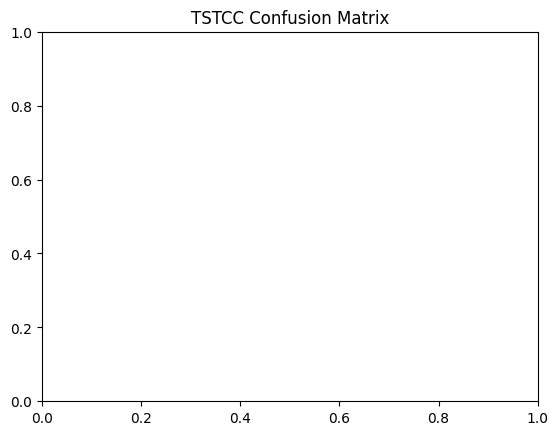

In [6]:
#main
# Args selections
start_time = datetime.now()

parser = argparse.ArgumentParser()

######################## Model parameters ########################
home_dir = os.getcwd()


class Args:
      experiment_description = 'Exp1'  #default='Exp1', type=str, help='Experiment Description'
      run_description = 'run1'  #default='run1', type=str, help='Experiment Description'
      seed = 0  #default=0, type=int, help='seed value'
      training_mode = 'train_linear'   #default='supervised', type=str, help='Modes of choice: random_init, supervised, self_supervised, fine_tune, train_linear'
      selected_dataset = 'ECG5000'    #default='ECG5000', type=str, help='Dataset of choice: ECG200, ECG5000, arrythmia, AtrialFibrillation, CinCECGTorso, ECGFiveDays, Heartbeat'
      logs_save_dir = '/content/drive/MyDrive/FYP_Nur_Time_Series_Representation_using_CL-main/TSTCC/logs'
      home_path = home_dir #default=home_dir, type=str, help='Project home directory'

args = Args()

#device = torch.device('cuda') #default='cuda', type=str, help='cpu or cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
experiment_description = args.experiment_description
data_type = args.selected_dataset
method = 'TS-TCC'
training_mode = args.training_mode
run_description = args.run_description

logs_save_dir = args.logs_save_dir
os.makedirs(logs_save_dir, exist_ok=True)


exec(f'from config_files.{data_type}_Configs import Config as Configs')
configs = Configs()

# ##### fix random seeds for reproducibility ########
SEED = args.seed
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
#####################################################

experiment_log_dir = os.path.join(logs_save_dir, experiment_description, run_description, training_mode + f"_seed_{SEED}")
os.makedirs(experiment_log_dir, exist_ok=True)

# loop through domains
counter = 0
src_counter = 0


# Logging
log_file_name = os.path.join(experiment_log_dir, f"logs_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.log")
logger = _logger(log_file_name)
logger.debug("=" * 45)
logger.debug(f'Dataset: {data_type}')
logger.debug(f'Method:  {method}')
logger.debug(f'Mode:    {training_mode}')
logger.debug("=" * 45)

# Load datasets
data_path = f"./data/{data_type}"
train_dl, valid_dl, test_dl = data_generator(data_path, configs, training_mode)
logger.debug("Data loaded ...")

# Load Model
model = base_Model(configs).to(device)
temporal_contr_model = TC(configs, device).to(device)

if training_mode == "fine_tune":
    # load saved model of this experiment
    load_from = os.path.join(os.path.join(logs_save_dir, experiment_description, run_description, f"self_supervised_seed_{SEED}", "saved_models"))
    chkpoint = torch.load(os.path.join(load_from, "ckp_last.pt"), map_location=device)
    pretrained_dict = chkpoint["model_state_dict"]
    model_dict = model.state_dict()
    del_list = ['logits']
    pretrained_dict_copy = pretrained_dict.copy()
    for i in pretrained_dict_copy.keys():
        for j in del_list:
            if j in i:
                del pretrained_dict[i]
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

if training_mode == "train_linear" or "tl" in training_mode:
    load_from = os.path.join(os.path.join(logs_save_dir, experiment_description, run_description, f"self_supervised_seed_{SEED}", "saved_models"))
    chkpoint = torch.load(os.path.join(load_from, "ckp_last.pt"), map_location=device)
    pretrained_dict = chkpoint["model_state_dict"]
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # delete these parameters (Ex: the linear layer at the end)
    del_list = ['logits']
    pretrained_dict_copy = pretrained_dict.copy()
    for i in pretrained_dict_copy.keys():
        for j in del_list:
            if j in i:
                del pretrained_dict[i]

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    set_requires_grad(model, pretrained_dict, requires_grad=False)  # Freeze everything except last layer.

if training_mode == "random_init":
    model_dict = model.state_dict()

    # delete all the parameters except for logits
    del_list = ['logits']
    pretrained_dict_copy = model_dict.copy()
    for i in pretrained_dict_copy.keys():
        for j in del_list:
            if j in i:
                del model_dict[i]
    set_requires_grad(model, model_dict, requires_grad=False)  # Freeze everything except last layer.



model_optimizer = torch.optim.Adam(model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)
temporal_contr_optimizer = torch.optim.Adam(temporal_contr_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)


if training_mode == "self_supervised":  # to do it only once
    copy_Files(os.path.join(logs_save_dir, experiment_description, run_description), data_type)

# Trainer
Trainer(model, temporal_contr_model, model_optimizer, temporal_contr_optimizer, train_dl, valid_dl, test_dl, device, logger, configs, experiment_log_dir, training_mode)

if training_mode != "self_supervised":
    # Testing
    #outs = model_evaluate(model, temporal_contr_model, test_dl, device, training_mode)
    #total_loss, total_acc, pred_labels, true_labels = outs
    #total_loss, total_acc, f1, recall, precision, pred_labels, true_labels = model_evaluate(model, temporal_contr_model, test_dl, device, training_mode)
    total_loss, total_acc, f1, recall, precision, pred_labels, true_labels = model_evaluate(model, temporal_contr_model, test_dl, device, training_mode)
    _calc_metrics(pred_labels, true_labels, experiment_log_dir, args.home_path)

logger.debug(f"Training time is : {datetime.now()-start_time}")